In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The model that we are using is the VGG-19 model, which has 19 layers. VGG-19 Deep Convolutional Network is used as a Transfer Learning framework where the VGGNet comes pre-trained on the ImageNet dataset. For the experiment, we will use the CIFAR-10 dataset and classify the image objects into 10 classes. 

In this experiment, we will be using the CIFAR-10 dataset which is a publically available image data set provided by the Canadian Institute for Advanced Research (CIFAR). It consists of 60000 32×32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent aeroplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 50000 training images and 10000 test images in this dataset.

So the following steps are to be taken to address this problem. 

**Step 1: Importing the required libraries**

In the first step, we are going to import all the necessary libraries required to through this experiment.

In [2]:
# importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
# For Transfer Learning
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizer_v2.adam import Adam
from keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.utils.np_utils import to_categorical
# Keras library for CIFAR-10 dataset
from keras.datasets import cifar10

**Step 2: Load the dataset**

Now in the very beginning step let’s import the CIFAR data as separate training and testing tests. 

In [3]:
# Downloading the CIFAR dataset
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


So we have only the training dataset and a testing dataset, to validate the performance while training the model a separate validation set is a must to have. Below the above training data, we will perceive 80% portion of it as training data and the rest will be used as a validation set.

In [4]:
# Defining training and test sets
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train) 
# Dimension of the dataset
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((37500, 32, 32, 3), (37500, 1))
((12500, 32, 32, 3), (12500, 1))
((10000, 32, 32, 3), (10000, 1))


As we can see, for training the model we have 37500 samples of images, 12500 for validating the model and 10000 samples to evaluate the performance of the trained model. 

**Step 3: Data preprocessing**

In this section, first, we will represent the category as sparse values that is one hot encoding. 

In [5]:
# One Hot Encoding
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)
# Now let’s check the shape of the data.
# Verifying the dimension after one hot encoding
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((37500, 32, 32, 3), (37500, 10))
((12500, 32, 32, 3), (12500, 10))
((10000, 32, 32, 3), (10000, 10))


As you can see we have successfully converted the target variable into a one-hot encoding representation. Now let’s use the ImageDataGenerator module to create the batches of the images so that while training we can feed data sequentially. Below, we will initiate the separate data generator function for each phase, that is training, testing, and validation. 

In [6]:
# Image Data Augmentation
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
test_generator = ImageDataGenerator()

Now we have initialized the data generator. Now let’s fit the generator on the respective dataset.



In [7]:
# Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

**Step 4: Loading and training VGG19**

Now we will start with building the model, first, we will initialize the rained model that VGG-19 with pre-trained weights from the ImageNet competition.   

In [8]:
# Defining the VGG Convolutional Neural Net
base_model = VGG19(include_top = False, weights = 'imagenet',
                input_shape = (32,32,3), classes = y_train.shape[1])

2023-02-05 13:56:17.947135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 13:56:17.948074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 13:56:18.067836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 13:56:18.068676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 13:56:18.069523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

80150528/80134624 [==============================] - 0s 0us/step


Above is the base model that we have initialized, now we will add the last classifier model on top of the above model. Below we will first create Keras sequential model and will first add the base model that is the VGG-19 model and latter will add 4 dense layers with activation function as ReLU and the last layer will be the classifier layer with 10 units and softmax as the activation function.

In [9]:
# Adding the final layers to the above base models where the actual classification is done in the dense layers
model= Sequential()
model.add(base_model)
model.add(Flatten())
#Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu')))
model.add(Dense(256,activation=('relu')))
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
model.add(Dropout(.2))
model.add(Dense(10,activation=('softmax')))

Now let’s check the model summary so that we can ensure that all the layers and parameters are intact. 

In [10]:
# Checking the final model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

As we can see there are a total of 21240010 parameters to be trained. Now we will initialize the hyperparameter of the model such as batch size, epochs, and learning rate.

In [11]:
# Initializing the hyperparameters
batch_size= 100
epochs=50
learn_rate=.001

As we are dealing with a multi-class problem so the optimal loss function will be the Categorical_crossentropy and to optimize this loss function adam optimizer is to be used. 

In [12]:
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['acc'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Now we have compiled the model with loss function and optimizer function along with we have also initialized the accuracy metrics to check the accuracy of the model through the training. 

Below we will start the training model, the model will train for the 50 epochs and for each epoch 375 samples will be utilized.  

In [13]:
# Training the model
history = model.fit_generator(train_generator.flow(x_train, y_train, batch_size= 100), epochs = epochs,
                 steps_per_epoch = x_train.shape[0]//batch_size,
                 validation_data = val_generator.flow(x_val, y_val, batch_size = 100))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-02-05 13:56:23.612271: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-02-05 13:56:25.964524: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


375/375 [==============================] - 41s 79ms/step - loss: 2.3779 - acc: 0.0997 - val_loss: 2.3029 - val_acc: 0.0985
Epoch 2/50
375/375 [==============================] - 29s 77ms/step - loss: 2.3028 - acc: 0.0999 - val_loss: 2.3028 - val_acc: 0.0984
Epoch 3/50
375/375 [==============================] - 29s 79ms/step - loss: 2.3028 - acc: 0.1002 - val_loss: 2.3031 - val_acc: 0.0984
Epoch 4/50
375/375 [==============================] - 30s 79ms/step - loss: 2.3029 - acc: 0.0995 - val_loss: 2.3029 - val_acc: 0.0988
Epoch 5/50
375/375 [==============================] - 29s 78ms/step - loss: 2.3028 - acc: 0.0979 - val_loss: 2.3028 - val_acc: 0.0995
Epoch 6/50
375/375 [==============================] - 29s 79ms/step - loss: 2.3028 - acc: 0.0997 - val_loss: 2.3027 - val_acc: 0.0988
Epoch 7/50
375/375 [==============================] - 30s 79ms/step - loss: 2.3027 - acc: 0.1013 - val_loss: 2.3028 - val_acc: 0.0984
Epoch 8/50
375/375 [==============================] - 29s 78ms/step - los

As we can see the loss and accuracy at the 50 epoch are 0.53 and 0.8282 respectively.  

**Step 5: Evaluating the model**

Now in this step, we will start evaluating the model, first, we will plot the training loss and accuracy curve for both training and validation data. 

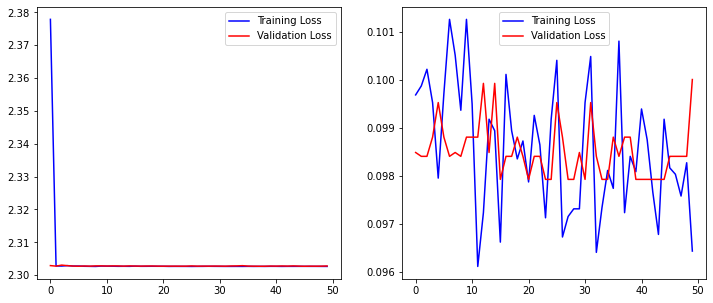

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],color='b',label='Training Loss')
plt.plot(history.history['val_loss'],color='r',label='Validation Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['acc'],color='b',label='Training Loss')
plt.plot(history.history['val_acc'],color='r',label='Validation Loss')
plt.legend()

As we can see in the first graph validation loss is following the training loss properly and converging towards zero. And in the second graph, the accuracies are also increasing very well. Now let’s obtain the prediction on the test data. 

In [15]:
# Making prediction
y_pred=model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis=1)

To validate the performance of the metrics we should obtain the confusion matrix so that we can have an idea of how the classes are being predicted. 

Below we are defining the function which will plot the confusion metrics.

In [16]:
# # Defining function for confusion matrix plot
# def plot_confusion_matrix(y_true, y_pred, classes,
#                        normalize=False,
#                        title=None,
#                        cmap=plt.cm.Blues):
# if not title:
#      if normalize:
#          title = 'Normalized confusion matrix'
#      else:
#          title = 'Confusion matrix, without normalization'
# # Compute confusion matrix
# cm = confusion_matrix(y_true, y_pred)
# if normalize:
#      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#      print("Normalized confusion matrix")
# else:
#      print('Confusion matrix, without normalization')
# # print (confusion matrix)
# fig, ax = plt.subplots(figsize=(7,7))
# im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
# ax.figure.colorbar(im, ax=ax)
# # We want to show all ticks...
# ax.set(xticks=np.arange(cm.shape[1]),
#         yticks=np.arange(cm.shape[0]),
#         # ... and label them with the respective list entries
#         xticklabels=classes, yticklabels=classes,
#         title=title,
#         ylabel='True label',
#         xlabel='Predicted label')
# #Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#           rotation_mode="anchor")
# # Loop over data dimensions and create text annotations.
# fmt = '.2f' if normalize else 'd'
# thresh = cm.max() / 2.
# for i in range(cm.shape[0]):
#      for j in range(cm.shape[1]):
#          ax.text(j, i, format(cm[i, j], fmt),
#                  ha="center", va="center",
#                  color="white" if cm[i, j] > thresh else "black")
# fig.tight_layout()
# return ax